# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
count = 0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    count = count+1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
print(count)

Total score (averaged over agents) this episode: 0.0824999981559813
1001


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### this section create model class

In [7]:
# create neural network policy and optimizer
import torch
import torch.nn as nn
import torch.nn.functional as F

# set up a neural net that outputs actions, sigma for each action and state value
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    
    # initialize layers
    def __init__(self, s_size=33, h_size=32, a_size=4):
        super(Policy, self).__init__()

        
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size)
        
        self.fc_critic1 = nn.Linear(s_size, h_size)
        self.fc_critic2 = nn.Linear(h_size, h_size)
        
        self.fc_action = nn.Linear(h_size, a_size)
        self.fc_value = nn.Linear(h_size, 1)
        self.fc_sigma = nn.Linear(h_size, a_size)
        
#         self.std = nn.Parameter(torch.ones(1, a_size))
        # Standard deviations approximated seperately
#         self.register_parameter('log_sigma', None)
#         self.log_sigma = nn.Parameter(torch.ones(1, action_size), requires_grad=True)
                
    # forward function for calculating mu, sigma and value
    def forward(self, state):
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # action outputs
#         mu = (self.fc_action(x))
        mu = F.tanh(self.fc_action(x))
        # sigma output
#         sigma = F.softplus(self.fc_sigma(x))
        sigma = F.sigmoid(self.fc_sigma(x))
#         sigma = self.log_sigma.expand(mu.shape)

        # critic value output
        x2 = F.relu(self.fc_critic1(state))
        x2 = F.relu(self.fc_critic2(x2))
        value = self.fc_value(x2)
        
        return mu, sigma, value
    
    
# run your own policy!
policy=Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

### this section define the function which generate trajectories

In [8]:
## build function that collect history data
from torch.distributions import Normal

def collect_trajectories(env, policy, tmax=200, rand_start=False, num_agents=20, state_size=33, action_size=4):
    action_list = []
    state_list = []
    reward_list = []
    prob_list = []
    
    # reset environment
    brain_name = env.brain_names[0]
    env_info = env.reset(train_mode=True)[brain_name] 
            
    if rand_start == True:
        action = np.random.randn(num_agents, action_size)
        action = np.clip(actions, -0.1, 0.1) 
        env_info = env.step(action)[brain_name] 
    
    # get starting state
    state_current = env_info.vector_observations
    
    for t in range(tmax):
        # append current state to state list
        state_list.append(state_current)
        
        # map current state to mu_current, sigma_current
        state_current = torch.from_numpy(state_current).to(torch.float).to(device)
        mu_current, sigma_current, value_current = policy(state_current)
        
        # create distribution object
        dist = Normal(mu_current, sigma_current)
        
        # get action
        act_current = dist.sample()
        act_current = torch.clamp(act_current, -1, 1)
        
        # calculate probabiliy of act_current
        prob = torch.exp(dist.log_prob(act_current))
        prob = prob.cpu().detach().numpy()
        
        # get reward, done flag and state_next
        act_current = act_current.cpu().detach().numpy()
        env_info = env.step(act_current)[brain_name]
        reward = env_info.rewards
        done = env_info.local_done 
        state_next = env_info.vector_observations
        
        # append state_current, act_current, reward and done flag into list
        action_list.append(act_current)
        reward_list.append(reward)
        prob_list.append(prob)
        
        # assign state_next to state_current
        state_current = state_next
        
        if any(done):
            break
    
    return state_list, action_list, prob_list, reward_list
            

### this section define the function that calculate loss

In [9]:
# helper function used in clipped_surrogate
def Cal_future_reward(rewards, discount):
    # reterive number of time step
    n_step = len(rewards)    
    
    # create reward_future which will store all the future rewards
    rewards = np.asarray(rewards)
    reward_future = np.zeros(np.shape(rewards))
    reward_future[-1] = rewards[-1]
    for i in range(1, n_step):
        reward_future[n_step-1-i] = rewards[n_step-1-i] + reward_future[n_step-i]*discount

    return reward_future


# function for calculating loss
def clipped_surrogate(policy, states, actions, prob_old, rewards, discount = 0.995, epsilon=0.2, beta=0.01, mse_w = 0.5):
    
    # calculate future rewards
    reward_future = Cal_future_reward(rewards, discount)
    
    # expand dimension to the dimension of output from policy and transfer variable to tensor
    reward_future = np.expand_dims(reward_future, axis = 2)
    reward_future = torch.tensor(reward_future, dtype=torch.float, device=device) 
    
#     # normalize feature reward
#     reward_mean = np.mean(reward_future, axis=1)
#     std = np.std(reward_future, axis=1) + 1.0e-10
#     rewards_normalized = (reward_future - reward_mean[:,np.newaxis])/std[:,np.newaxis]

    # calculate mu, sigma and state value
    states = torch.tensor(states, dtype=torch.float, device=device)
    mu, sigma, value = policy(states)
    
    # calculate current action probability
    actions = torch.tensor(actions, dtype=torch.float, device=device)
    dist_training = Normal(mu, sigma)
    prob_new = torch.exp(dist_training.log_prob(actions))
    
    # calculate probability ratio = prob_new/prob_old
    prob_old = torch.tensor(prob_old, dtype=torch.float, device=device)
    ratio = prob_new/prob_old
    
    # calculate td_error
    td_error = reward_future - value.detach()
    td_mean = torch.mean(td_error, 1,keepdim=True)
    td_std = torch.std(td_error, 1,keepdim=True)
    td_normal = (td_error-td_mean)/(td_std+1e-10)
#     n_step = len(rewards)
#     rewards = np.expand_dims(rewards, axis = 2)
#     rewards = torch.tensor(rewards, dtype=torch.float, device=device) 
#     td_error = torch.zeros_like(rewards)
#     td_error[-1] = rewards[-1] - value[-1]
#     for i in range(n_step-1):
#         td_error[i] = rewards[i] + discount*value[i+1] - value[i]
    

    # calculate clipped loss function
    ratio_clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate_loss = -torch.mean(torch.min(ratio*td_normal, ratio_clip*td_normal))

    # calculate MSE loss value 
    mse_loss = F.mse_loss(reward_future, value)
    
    # calculate entropy regularization term
    entropy_loss = -torch.mean(dist_training.entropy())
#     entropy = -(prob_new*torch.log(prob_old+1.e-10)+ \
#         (1.0-prob_new)*torch.log(1.0-prob_old+1.e-10))

    
    # total loss
    total_loss = clipped_surrogate_loss + mse_w*mse_loss + beta*entropy_loss
    
    return total_loss

In [10]:
# test code
states, actions, prob_old, rewards = collect_trajectories(env, policy)

In [11]:
loss = clipped_surrogate(policy, states, actions, prob_old, rewards)

### this section is the main training loop

In [12]:
# main training function
from parallelEnv import parallelEnv
# keep track of how long training takes

# load policy if needed
# policy = torch.load('PPO.policy')

# training loop max iterations
episode = 100

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

discount_rate = .99
epsilon = 0.2
beta = 0.01
mse_w = 0.1
tmax = 800
SGD_epoch = 1
step = 10

# keep track of progress
mean_rewards = []

for e in range(episode):
    
    
    # collect trajectories
    states, actions, probs_old, rewards = collect_trajectories(env, policy, tmax, False, num_agents, state_size, action_size)
                       
    total_rewards = np.sum(rewards, axis=0)
    
    # calculate minibatch size
    minibatch_size = len(states)//SGD_epoch
    
    # gradient ascent step
    for _ in range(step):
        
        for i in range(SGD_epoch):

            # retreive minibatch data
            ind_start = i*minibatch_size
            ind_end = min([(i+1)*minibatch_size,len(states)])
            
            states_mini = states[ind_start:ind_end]
            actions_mini = actions[ind_start:ind_end]
            probs_old_mini = probs_old[ind_start:ind_end]
            rewards_mini = rewards[ind_start:ind_end]

            # uncomment to utilize your own clipped function!
            L = clipped_surrogate(policy, states_mini, actions_mini, probs_old_mini, rewards_mini, 
                                  discount_rate, epsilon, beta, mse_w)

            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=1.0
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


Episode: 20, score: 0.835500
[ 1.21999997  0.62999999  1.05999998  1.23999997  0.67999998  0.40999999
  0.63999999  0.56999999  0.97999998  1.34999997  0.07        0.38999999
  0.26999999  1.68999996  0.85999998  0.25999999  0.48999999  2.29999995
  1.42999997  0.17      ]


Episode: 40, score: 0.886000
[ 1.02999998  1.01999998  1.04999998  1.12999997  0.57999999  1.07999998
  0.70999998  0.80999998  0.61999999  0.51999999  1.09999998  0.98999998
  0.85999998  0.65999999  0.51999999  1.15999997  0.63999999  1.79999996
  0.93999998  0.49999999]


Episode: 60, score: 0.841000
[ 0.65999999  1.04999998  1.67999996  0.77999998  1.02999998  0.89999998
  0.79999998  1.70999996  0.84999998  1.03999998  0.          0.59999999
  0.53999999  0.58999999  0.          1.71999996  1.05999998  0.42999999
  0.92999998  0.44999999]


Episode: 80, score: 0.800500
[ 0.28999999  0.92999998  0.31999999  0.72999998  0.          1.25999997
  1.08999998  0.          0.22999999  2.13999995  1.03999998  0.33999999
  0.87999998  1.90999996  1.00999998  0.50999999  0.49999999  0.57999999
  1.29999997  0.94999998]


Episode: 100, score: 0.933000
[ 2.01999995  0.25999999  0.37999999  0.26999999  0.67999998  1.36999997
  1.10999998  0.94999998  1.74999996  1.72999996  0.47999999  0.79999998
  0.37999999  1.45999997  2.18999995  0.04        0.91999998  0.32999999
  0.86999998  0.66999999]


(<matplotlib.figure.Figure at 0x7f873f1c53c8>,
 [<matplotlib.lines.Line2D at 0x7f873f15b828>])

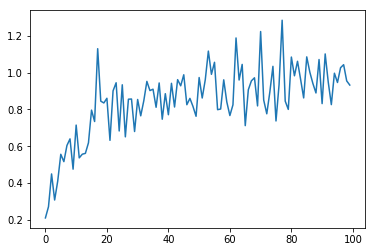

In [14]:
import matplotlib.pyplot as plt
plt.figure(1),plt.plot(mean_rewards)